In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
from skimage import io
from skimage import data
import numpy as np
import math
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5) # width and height
mpl.rc('image', cmap='gray')

In [2]:
def rgb2gray(img):
    return 0.2125*img[:,:,0] + 0.7154*img[:,:,1] + 0.0721*img[:,:,2]

In [14]:
def toBlocks(img, size_h=8, size_w=8):
    #print("in toBlocks()")
    h, w = img.shape
    h, w = math.floor(h/size_h), math.floor(w/size_w)
    blocks = np.empty((h, w, size_h, size_w))
    for J in range(h):
        for I in range(w):
            new_block = np.zeros((size_h, size_w))
            y_start, x_start = J*size_h, I*size_w
            for j in range(size_h):
                for i in range(size_w):
                    new_block[j][i] = img[y_start+j][x_start+i]
            blocks[J][I] = new_block
    return blocks

In [13]:
def fromBlocks(img):
    (img_h, img_w, block_h, block_w) = img.shape
    output = np.zeros((img_h*block_h, img_w*block_w))
    for J in range(img_h):
        for I in range(img_w):
            block = img[J, I]
            for j in range(block_h):
                for i in range(block_w):
                    y = J * block_h + j
                    x = I * block_w + i
                    output[y, x] = block[j, i]
    return output

In [5]:
def averagePixDiff(im1, im2):
    if im1.shape != im2.shape:
        print("(in avePixDiff) Error: the shapes of two arrays doesn' match")
        return -1
    return (np.abs(im1-im2)).mean()

In [6]:
def smallestAvePixDiffBlock(im, blocks):
    min = 255
    best = blocks[0]
    for block in blocks:
        diff = averagePixDiff(im, block)
        if diff < min:
            min = diff
            best = block
    return best

In [19]:
def getCharacterString():
    CHARACTERS = ""
    for x in range(32,127): CHARACTERS += chr(x)
    return CHARACTERS

In [16]:
# !!! Need to change image used if wanting more characters
def getCharBlocks(sentence, fontName, fontSize, block_h, block_w):
    myFont = ImageFont.truetype(fontName, fontSize)
    characters = Image.open('ascii_char_holder.png')
    drawer = ImageDraw.Draw(characters)
    drawer.text((0,0), sentence, font=myFont, fill=0)
    #characters.show()
    characterArray = np.asarray(characters)
    characterArray = rgb2gray(characterArray)
    #print(characterArray.shape)
    charBlocks = toBlocks(characterArray, block_h, block_w)
    return charBlocks[0]

In [36]:
def getAsciiImage(image, charBlocks):
    (bH, bW) = charBlocks[0].shape
    image_blocks = toBlocks(image, bH, bW)
    ascii_blocks = np.empty(image_blocks.shape)
    (imH, imW, rub, ish) = image_blocks.shape
    for iy, ix in np.ndindex(imH, imW):
        block = image_blocks[iy, ix]
        ascii_blocks[iy, ix] = smallestAvePixDiffBlock(block, charBlocks)
    return fromBlocks(ascii_blocks)

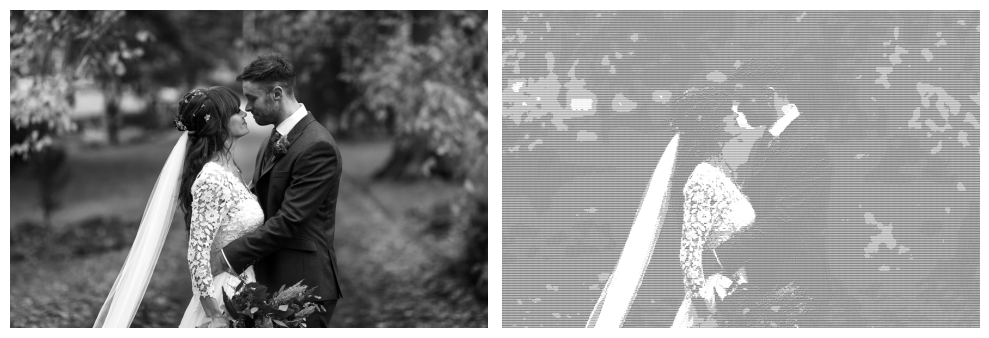

In [56]:
# IMAGES
astronaut = rgb2gray(data.astronaut())


# SET VARIABLES
BLOCK_H, BLOCK_W = 7, 5
font_size = 8
font_name = "courier.ttf"
CHARACTERS = getCharacterString()
charBlocks = getCharBlocks(CHARACTERS, font_name, font_size, BLOCK_H, BLOCK_W)

# CHOSE IMAGE AND GET ASCII IMAGE
# Lenna.png, cliff_tree.jpg, wedding.jpg
image_name = "wedding.jpg"
image = rgb2gray(io.imread(image_name))
ascii_image = getAsciiImage(image, charBlocks)

# DISPLAY
images = (image, ascii_image)
fig, ax = plt.subplots(1, len(images))
for i, im in enumerate(images):
    ax[i].imshow(im), ax[i].axis('off')
fig.tight_layout()

# GET PNG
ascii_image_image = Image.fromarray(ascii_image)
ascii_image_image.show()